## Using Deep Learning Approaces to Detect Arthritis in Radiographs

This project will explore the application of CNN and RNN approaches as potential diagnostic tools for arthritis, using a dataset of human knee (patellar joint) radiographs. My hope is to expand it to veterinary applications as more patellar radiographs from different species comes available. 

The data used in this project can be found at this URL: https://www.kaggle.com/datasets/shashwatwork/knee-osteoarthritis-dataset-with-severity/data

Note that for this project, I chose to download the data directly to my machine. I've prevented it from uploading to git using .gitignore. If you would like to replicate this code, you'll need to download the data files from the abovementioned link. 

This arthritis detection project includes the following three deliverables:
1. This notebook
2. A video presentation (powerpoint slides will be available on Git)
3. a public GitHub repository, found here: https://github.com/Kate-Zilla/deep-learning-arthritis-detection 


## Problem Description:
The goal of this project is to determine the applicability of deep learning approaches when it comes to arthritis detection and diagnosis. 


Import Statements

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import random



RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

pd.set_option('display.max_columns',120)
sns.set_context("notebook")

path configuration

In [2]:
BASE_DIR = os.path.join(os.getcwd(), "data")

train_dir = os.path.join(BASE_DIR, "train")
val_dir   = os.path.join(BASE_DIR, "val")
test_dir  = os.path.join(BASE_DIR, "test")

print("Base directory:", BASE_DIR)
print("Train directory:", train_dir)
print("Val directory:", val_dir)
print("Test directory:", test_dir)

#image & training config
IMG_HEIGHT = 224
IMG_WIDTH  = 224
COLOR_MODE = "grayscale"
BATCH_SIZE = 32
NUM_CLASSES = 5
AUTOTUNE = tf.data.AUTOTUNE

Base directory: d:\arthritis_detection_deep_learning\deep-learning-arthritis-detection\data
Train directory: d:\arthritis_detection_deep_learning\deep-learning-arthritis-detection\data\train
Val directory: d:\arthritis_detection_deep_learning\deep-learning-arthritis-detection\data\val
Test directory: d:\arthritis_detection_deep_learning\deep-learning-arthritis-detection\data\test


# EDA: exploratory data analysis
Here I will take a peek into my data

In [3]:
def count_images_per_class(split_dir):
    counts = {}
    for label in sorted(os.listdir(split_dir)):
        label_path = os.path.join(split_dir, label)
        if os.path.isdir(label_path):
            n_images = len([
                f for f in os.listdir(label_path)
                if f.lower().endswith((".png", ".jpg", ".jpeg"))
            ])
            counts[int(label)] = n_images
    return counts

splits = {"train": train_dir, "val": val_dir, "test": test_dir}
rows = []

for split_name, split_path in splits.items():
    class_counts = count_images_per_class(split_path)
    for grade, count in class_counts.items():
        rows.append({"split": split_name, "grade": grade, "count": count})

eda_counts_df = pd.DataFrame(rows)
eda_counts_df


,split,grade,count
0,train,0,2286
1,train,1,1046
2,train,2,1516
3,train,3,757
4,train,4,173
5,val,0,328
6,val,1,153
7,val,2,212
8,val,3,106
9,val,4,27


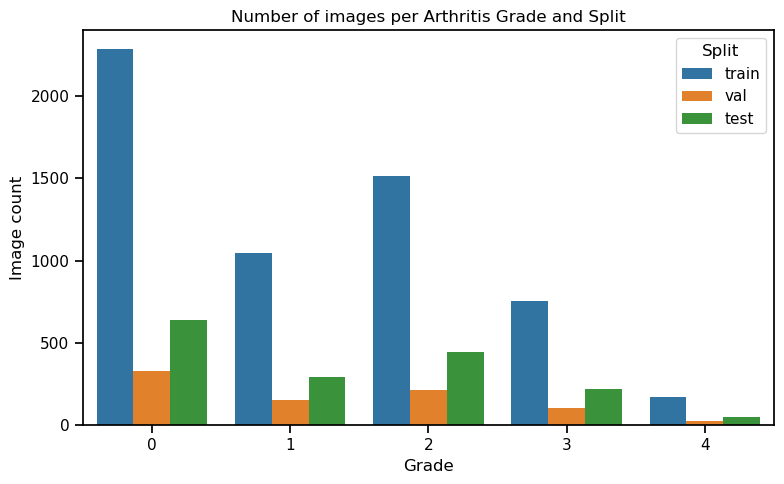

In [4]:
plt.figure(figsize=(8, 5))
sns.barplot(data=eda_counts_df, x="grade", y="count", hue="split")
plt.title("Number of images per Arthritis Grade and Split")
plt.xlabel("Grade")
plt.ylabel("Image count")
plt.legend(title="Split")
plt.tight_layout()
plt.show()

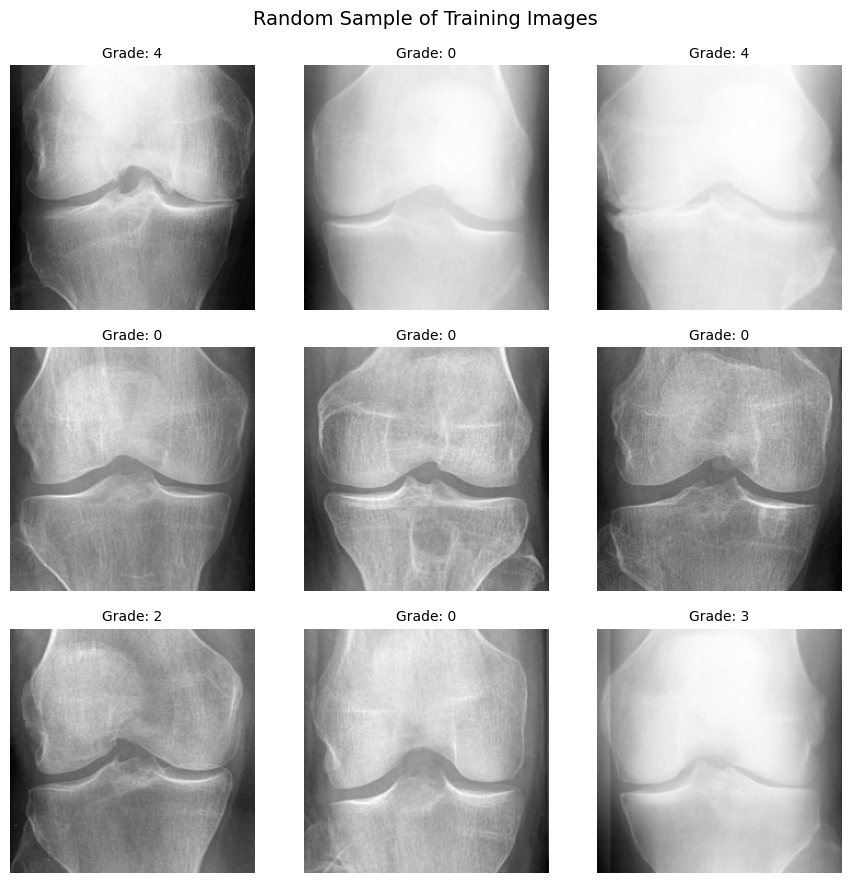

In [5]:
def get_all_image_paths(root_dir):
    """Return list of (filepath, label_int) tuples."""
    all_paths = []
    for label in sorted(os.listdir(root_dir)):
        label_dir = os.path.join(root_dir, label)
        if os.path.isdir(label_dir):
            imgs = [
                (os.path.join(label_dir, f), int(label))
                for f in os.listdir(label_dir)
                if f.lower().endswith((".png", ".jpg", ".jpeg"))
            ]
            all_paths.extend(imgs)
    return all_paths


#collect paths from train_dir (can change to val_dir or test_dir)
all_train_paths = get_all_image_paths(train_dir)

#randomly sample 9 images
sampled = random.sample(all_train_paths, 9)

#plot 3×3 grid
plt.figure(figsize=(9, 9))

for i, (img_path, label) in enumerate(sampled):
    img = Image.open(img_path).convert("L")
    
    plt.subplot(3, 3, i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"Grade: {label}", fontsize=10)
    plt.axis("off")

plt.suptitle("Random Sample of Training Images", fontsize=14)
plt.tight_layout()
plt.show()


for some more EDA, i will collect and view the image metadata

In [6]:
def collect_image_metadata(root_dir):
    """
    Walk through train/val/test folders and collect:
        - filepath
        - label (KL grade)
        - height
        - width
        - file size (KB)
    """
    records = []

    for split in ["train", "val", "test"]:
        split_path = os.path.join(root_dir, split)
        for label in sorted(os.listdir(split_path)):
            label_dir = os.path.join(split_path, label)
            if not os.path.isdir(label_dir):
                continue

            for fname in os.listdir(label_dir):
                if fname.lower().endswith((".png", ".jpg", ".jpeg")):
                    fpath = os.path.join(label_dir, fname)

                    try:
                        img = Image.open(fpath)
                        width, height = img.size
                        img.close()
                    except Exception as e:
                        print(f"Could not load {fpath}: {e}")
                        continue

                    size_kb = os.path.getsize(fpath) / 1024.0

                    records.append({
                        "filepath": fpath,
                        "split": split,
                        "label": int(label),
                        "width": width,
                        "height": height,
                        "file_size_kb": size_kb,
                    })

    return pd.DataFrame(records)


# Collect metadata
metadata_df = collect_image_metadata(BASE_DIR)
metadata_df.head()

,filepath,split,label,width,height,file_size_kb
0,d:\arthritis_detection_deep_learning\deep-lear...,train,0,224,224,18.356445
1,d:\arthritis_detection_deep_learning\deep-lear...,train,0,224,224,23.594727
2,d:\arthritis_detection_deep_learning\deep-lear...,train,0,224,224,15.313477
3,d:\arthritis_detection_deep_learning\deep-lear...,train,0,224,224,17.416992
4,d:\arthritis_detection_deep_learning\deep-lear...,train,0,224,224,20.323242


quickly confirm all files are the same width & height

In [7]:
expected_w, expected_h = 224, 224

mismatch_files = []

for idx, row in metadata_df.iterrows():
    w, h = row["width"], row["height"]
    if w != expected_w or h != expected_h:
        mismatch_files.append((row["filepath"], w, h))

if len(mismatch_files) == 0:
    print("All images are exactly 224x224.")
else:
    print(f"found {len(mismatch_files)} images that are not 224x224:")

All images are exactly 224x224.


## EDA Discussion:
all images are 224x224 .png files that appear in grayscale, as shown by the sample 3x3 grid, above. This data appears to be ideal for CNN and RNN applications. 

Now I will go ahead and create tf datasets so that I can efficiently and effectively build and train my models!

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True,
    seed=RANDOM_STATE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels="inferred",
    label_mode="int",
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=False
)

class_names = train_ds.class_names
print("Class names:", class_names)

Found 5778 files belonging to 5 classes.
Found 826 files belonging to 5 classes.
Found 1656 files belonging to 5 classes.
Class names: ['0', '1', '2', '3', '4']


Here I will prepare the data for training, including rescaling. 

In [9]:
def prepare_for_training(ds, shuffle=False):
    if shuffle:
        ds = ds.shuffle(buffer_size=1000, seed=RANDOM_STATE)
    ds = ds.cache()
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds_prep = prepare_for_training(train_ds, shuffle=True)
val_ds_prep   = prepare_for_training(val_ds)
test_ds_prep  = prepare_for_training(test_ds)

rescale = layers.Rescaling(1.0 / 255)

## CNN Model: Convolutional Neural Network
here i build my CNN model

In [10]:
def build_cnn_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1), num_classes=NUM_CLASSES):
    inputs = keras.Input(shape=input_shape)

    x = rescale(inputs)
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation="relu")(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

cnn_model = build_cnn_model()
cnn_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,938,501 (49.36 MB)

 Trainable params: 12,938,501 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

## Train CNN
Now i will train the CNN model:

In [11]:
cnn_model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history_cnn = cnn_model.fit(
    train_ds_prep,
    validation_data=val_ds_prep,
    epochs=30,
    callbacks=[early_stopping]
)

Epoch 1/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 86s 465ms/step - accuracy: 0.3873 - loss: 1.4160 - val_accuracy: 0.4056 - val_loss: 1.4221
Epoch 2/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 84s 465ms/step - accuracy: 0.3969 - loss: 1.3973 - val_accuracy: 0.4116 - val_loss: 1.3961
Epoch 3/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 84s 466ms/step - accuracy: 0.4083 - loss: 1.3804 - val_accuracy: 0.4165 - val_loss: 1.3816
Epoch 4/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 84s 461ms/step - accuracy: 0.4256 - loss: 1.3564 - val_accuracy: 0.4068 - val_loss: 1.3551
Epoch 5/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 85s 468ms/step - accuracy: 0.4408 - loss: 1.3053 - val_accuracy: 0.4407 - val_loss: 1.3033
Epoch 6/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 83s 461ms/step - accuracy: 0.4697 - loss: 1.2353 - val_accuracy: 0.4552 - val_loss: 1.2336
Epoch 7/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 83s 461ms/step - accuracy: 0.4946 - loss: 1.1761 - val_accuracy: 0.4600 - val_loss: 1.2090
Epoch 8/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 84s 464ms/step - accuracy: 0.5118 - loss: 1

Here I'll plot my CNN training history:

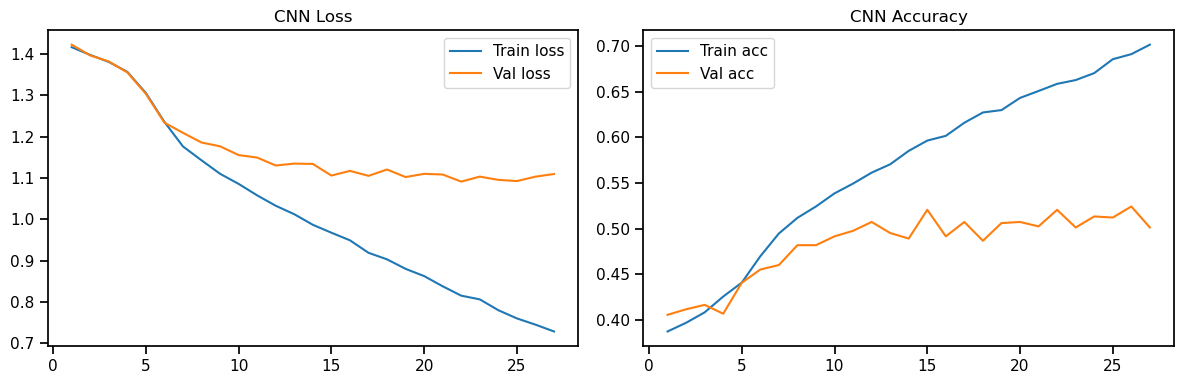

In [12]:
def plot_training_history(history, title_prefix="CNN"):
    hist = history.history
    epochs = range(1, len(hist["loss"]) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, hist["loss"], label="Train loss")
    plt.plot(epochs, hist["val_loss"], label="Val loss")
    plt.title(f"{title_prefix} Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, hist["accuracy"], label="Train acc")
    plt.plot(epochs, hist["val_accuracy"], label="Val acc")
    plt.title(f"{title_prefix} Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history_cnn, "CNN")

you can see that my validation loss slows significantly after the 15th epoch, and my validation accuracy levels off around the same time. Training loss and training accuracy continue to improve with each epoch. I could possibly get away with only 15 epochs if training this model was significant stress on my machine. As it stands, however, I am keeping the 30 epochs as a ~40 minute training period is acceptable to me with this particular machine. 

Now I will evaluate my CNN's performance, and also display a confusion matrix. 

52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.5272 - loss: 1.0919
CNN — Test accuracy: 0.527
              precision    recall  f1-score   support

           0       0.61      0.79      0.68       639
           1       0.22      0.14      0.17       296
           2       0.49      0.43      0.46       447
           3       0.53      0.53      0.53       223
           4       0.68      0.37      0.48        51

    accuracy                           0.53      1656
   macro avg       0.51      0.45      0.46      1656
weighted avg       0.50      0.53      0.50      1656



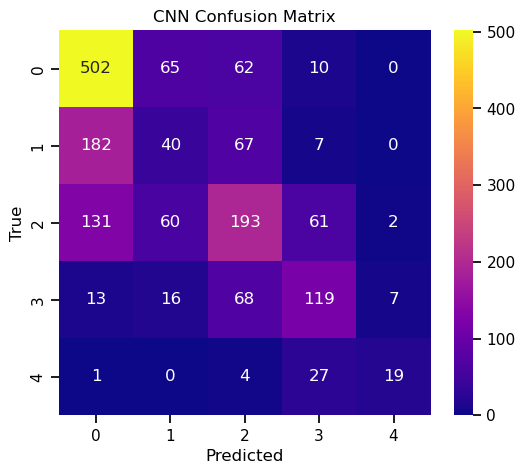

In [13]:
test_loss_cnn, test_acc_cnn = cnn_model.evaluate(test_ds_prep)
print(f"CNN — Test accuracy: {test_acc_cnn:.3f}")

from sklearn.metrics import confusion_matrix, classification_report

y_true, y_pred = [], []

for imgs, labels in test_ds_prep:
    preds = cnn_model.predict(imgs, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)
print(classification_report(y_true, y_pred))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="plasma",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("CNN Confusion Matrix")
plt.show()


some more diagnostic metrics for the CNN. I will use this info to compare this model to human accuracy.

=== CNN Diagnostic Metrics (Binary: Healthy vs Arthritic) ===
Sensitivity: 0.678
Specificity: 0.786
PPV:         0.834
NPV:         0.606
Accuracy:    0.720


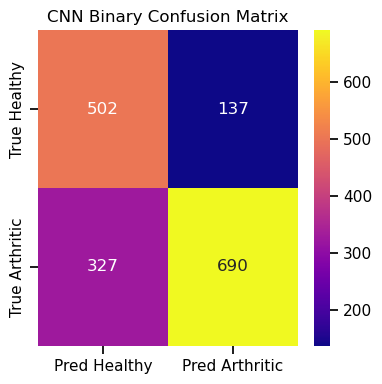

In [14]:
# Confusion Matrix Layout:
# cm = [[TN, FP],
#       [FN, TP]]
# BUT because this is multi-class 0–4, I will collapse to:
#   Healthy (0) vs Arthritic (1–4)

# Convert y_true and y_pred to binary
y_true_binary = (y_true > 0).astype(int)
y_pred_binary = (y_pred > 0).astype(int)

# Compute confusion matrix for binary labels
cm_bin = confusion_matrix(y_true_binary, y_pred_binary)
TN, FP, FN, TP = cm_bin.ravel()

# Compute metrics
sensitivity = TP / (TP + FN)          # True Positive Rate
specificity = TN / (TN + FP)          # True Negative Rate
ppv = TP / (TP + FP)                  # Precision / Positive Predictive Value
npv = TN / (TN + FN)                  # Negative Predictive Value
accuracy = (TP + TN) / cm_bin.sum()

print("=== CNN Diagnostic Metrics (Binary: Healthy vs Arthritic) ===")
print(f"Sensitivity: {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"PPV:         {ppv:.3f}")
print(f"NPV:         {npv:.3f}")
print(f"Accuracy:    {accuracy:.3f}")

# Plot binary confusion matrix in plasma
plt.figure(figsize=(4,4))
sns.heatmap(cm_bin, annot=True, fmt="d", cmap="plasma",
            xticklabels=["Pred Healthy","Pred Arthritic"],
            yticklabels=["True Healthy","True Arthritic"])
plt.title("CNN Binary Confusion Matrix")
plt.tight_layout()
plt.show()


In [15]:
#store CNN metrics for later comparison:
cnn_accuracy      = accuracy        #from CNN binary metrics calculation
cnn_sensitivity   = sensitivity
cnn_specificity   = specificity
cnn_ppv           = ppv
cnn_npv           = npv

This confusion matrix shows some overlap in some of the arthritic grades, which does make sense as they were diagnosed by human doctors, so there is possibility of subjective judgement or judgemental error obscuring results. What is nice to see is the stark contrast between no arthritis and some arthritis. 

## RNN: Recurrent Neural Network
here i will approach the data using an RNN

first i will build the model:

In [16]:
def build_rnn_model(img_height=IMG_HEIGHT, img_width=IMG_WIDTH, num_classes=NUM_CLASSES):
    inputs = keras.Input(shape=(img_height, img_width, 1))

    x = rescale(inputs)
    x = layers.Reshape((img_height, img_width))(x)

    x = layers.LSTM(64)(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation="relu")(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

rnn_model = build_rnn_model()
rnn_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 224, 224)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        73,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,469 (306.52 KB)

 Trainable params: 78,469 (306.52 KB)

 Non-trainable params: 0 (0.00 B)

now i will train the RNN

In [17]:
rnn_model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

early_stopping_rnn = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history_rnn = rnn_model.fit(
    train_ds_prep,
    validation_data=val_ds_prep,
    epochs=30,
    callbacks=[early_stopping_rnn]
)

Epoch 1/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.3686 - loss: 1.4406 - val_accuracy: 0.3971 - val_loss: 1.4068
Epoch 2/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.3837 - loss: 1.4175 - val_accuracy: 0.3971 - val_loss: 1.4051
Epoch 3/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.3854 - loss: 1.4197 - val_accuracy: 0.3971 - val_loss: 1.4045
Epoch 4/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.3937 - loss: 1.4118 - val_accuracy: 0.3971 - val_loss: 1.4032
Epoch 5/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.3949 - loss: 1.4127 - val_accuracy: 0.3971 - val_loss: 1.4026
Epoch 6/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.3956 - loss: 1.4071 - val_accuracy: 0.3971 - val_loss: 1.4028
Epoch 7/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.3936 - loss: 1.4075 - val_accuracy: 0.3971 - val_loss: 1.4026
Epoch 8/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.3927 - loss: 1.4082 - val_accu

It is really interesting to note how quickly the same number of RNN epochs ran when opposed to the CNN epochs. 30 CNN epochs took about 40 minutes, while the 30 RNN epochs only took 1 minute and 52 seconds! 

now i will go ahead and evalue the RNN performance

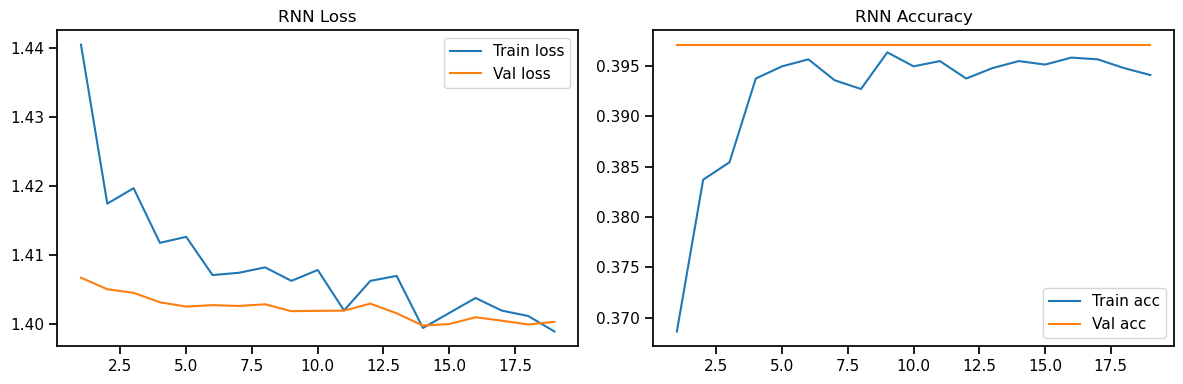

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3859 - loss: 1.4051
RNN — Test accuracy: 0.386


In [18]:
plot_training_history(history_rnn, "RNN")

test_loss_rnn, test_acc_rnn = rnn_model.evaluate(test_ds_prep)
print(f"RNN — Test accuracy: {test_acc_rnn:.3f}")

RNN confusion matrix & metrics

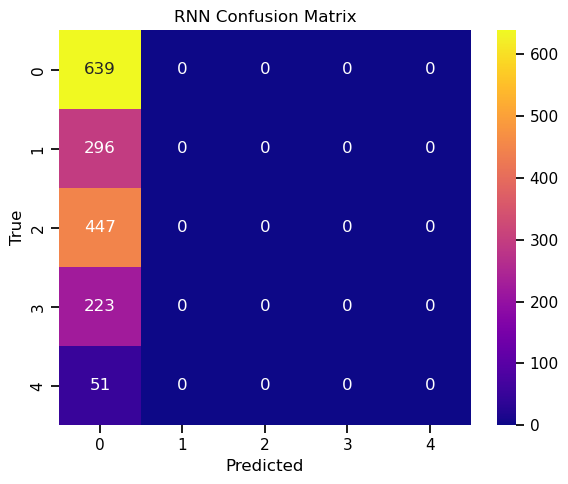

=== RNN Diagnostic Metrics (Binary: Healthy vs Arthritic) ===
Sensitivity: 0.000
Specificity: 1.000
PPV:         nan
NPV:         0.386
Accuracy:    0.386


C:\Users\Katie\AppData\Local\Temp\ipykernel_30600\1976374491.py:33: RuntimeWarning: invalid value encountered in scalar divide
  ppv = TP / (TP + FP)


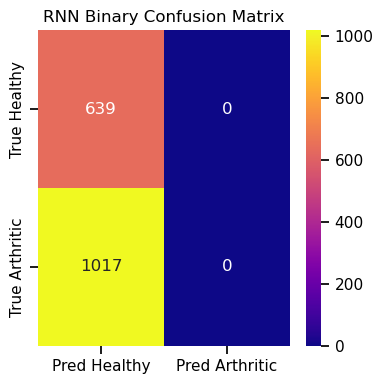

In [19]:
y_true_rnn = []
y_pred_rnn = []

for imgs, labels in test_ds_prep:
    preds = rnn_model.predict(imgs, verbose=0)
    y_true_rnn.extend(labels.numpy())
    y_pred_rnn.extend(np.argmax(preds, axis=1))

y_true_rnn = np.array(y_true_rnn)
y_pred_rnn = np.array(y_pred_rnn)

# Multi-class confusion matrix for RNN
cm_rnn = confusion_matrix(y_true_rnn, y_pred_rnn)

plt.figure(figsize=(6,5))
sns.heatmap(cm_rnn, annot=True, fmt="d", cmap="plasma",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("RNN Confusion Matrix")
plt.tight_layout()
plt.show()

# === Diagnostic Metrics (Binary: Healthy vs Arthritic) ===
y_true_rnn_binary = (y_true_rnn > 0).astype(int)
y_pred_rnn_binary = (y_pred_rnn > 0).astype(int)

cm_bin_rnn = confusion_matrix(y_true_rnn_binary, y_pred_rnn_binary)
TN, FP, FN, TP = cm_bin_rnn.ravel()

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
ppv = TP / (TP + FP)
npv = TN / (TN + FN)
accuracy = (TP + TN) / cm_bin_rnn.sum()

print("=== RNN Diagnostic Metrics (Binary: Healthy vs Arthritic) ===")
print(f"Sensitivity: {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"PPV:         {ppv:.3f}")
print(f"NPV:         {npv:.3f}")
print(f"Accuracy:    {accuracy:.3f}")

plt.figure(figsize=(4,4))
sns.heatmap(cm_bin_rnn, annot=True, fmt="d", cmap="plasma",
            xticklabels=["Pred Healthy","Pred Arthritic"],
            yticklabels=["True Healthy","True Arthritic"])
plt.title("RNN Binary Confusion Matrix")
plt.tight_layout()
plt.show()


In [20]:
#store RNN metrics for later comparison
rnn_accuracy      = accuracy        # from RNN binary metrics calculation
rnn_sensitivity   = sensitivity
rnn_specificity   = specificity
rnn_ppv           = ppv
rnn_npv           = npv

## Compare RNN vs CNN

In [21]:
print(f"CNN params: {cnn_model.count_params():,}")
print(f"RNN params: {rnn_model.count_params():,}")
print(f"CNN test accuracy: {test_acc_cnn:.3f}")
print(f"RNN test accuracy: {test_acc_rnn:.3f}")


CNN params: 12,938,501
RNN params: 78,469
CNN test accuracy: 0.527
RNN test accuracy: 0.386


Overall, it appears the CNN was a more accurate predictor. 

According to https://acrjournals.onlinelibrary.wiley.com/doi/full/10.1002/art.42368 (properly cited in README), radiographic diagnosis of knee osteoarthritis by doctors had an overall accuracy of 73%, with PPV of 88%, NPV of 66%, sensitivity of 54%, and specificity of 92%. 

Here I will build a dataframe that compares these metrics between doctor diagnoses, my CNN model, and my RNN model:

In [22]:
comparison_df = pd.DataFrame({
    "Metric": ["Accuracy", "Sensitivity", "Specificity", "PPV", "NPV"],
    "Doctor": [0.73, 0.54, 0.92, 0.88, 0.66],
    "CNN Model":    [cnn_accuracy, cnn_sensitivity, cnn_specificity, cnn_ppv, cnn_npv],
    "RNN Model":    [rnn_accuracy, rnn_sensitivity, rnn_specificity, rnn_ppv, rnn_npv]
}).round(3)

comparison_df


,Metric,Doctor,CNN Model,RNN Model
0,Accuracy,0.73,0.720,0.386
1,Sensitivity,0.54,0.678,0.000
2,Specificity,0.92,0.786,1.000
3,PPV,0.88,0.834,NaN
4,NPV,0.66,0.606,0.386


Here is a bar chart comparing results:

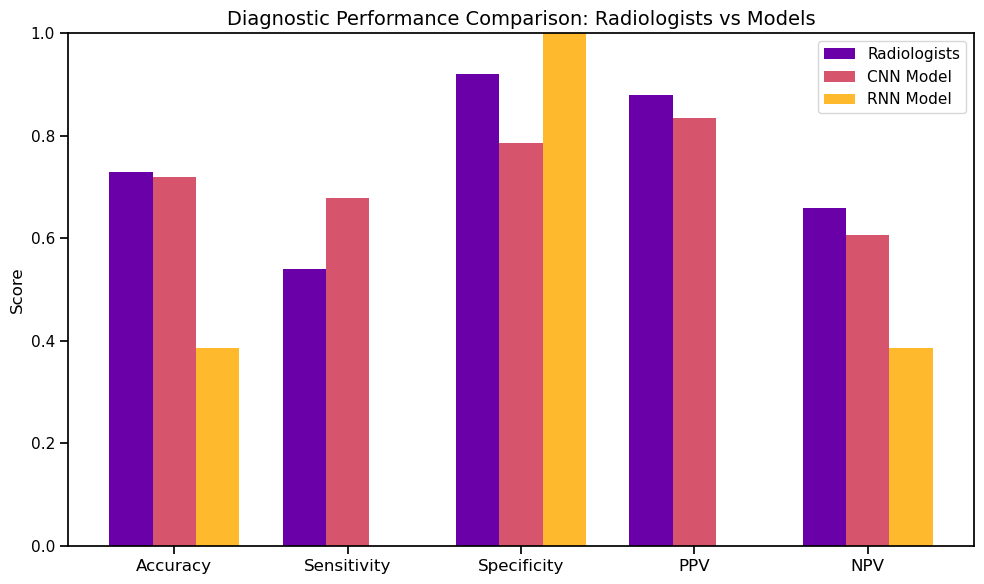

In [23]:
# remove radiologist/model names for plotting
metrics = comparison_df["Metric"].values
radiologists = comparison_df["Doctor"].values
cnn_vals = comparison_df["CNN Model"].values
rnn_vals = comparison_df["RNN Model"].values

x = np.arange(len(metrics))
width = 0.25

plt.figure(figsize=(10,6))

plt.bar(x - width, radiologists, width, label='Radiologists', color=plt.cm.plasma(0.2))
plt.bar(x,         cnn_vals,     width, label='CNN Model',     color=plt.cm.plasma(0.55))
plt.bar(x + width, rnn_vals,     width, label='RNN Model',     color=plt.cm.plasma(0.85))

plt.xticks(x, metrics, fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.ylim(0, 1.0)
plt.title("Diagnostic Performance Comparison: Radiologists vs Models", fontsize=14)

plt.legend()
plt.tight_layout()
plt.show()

## Discuss results:
My CNN model is extremely close to human accuracy. I am now, therefore, going to create an improved version to try to "beat" the human diagnostician. I'm going to improve data augmentation, add class weights, and attempt a slightly deeper filter size (trying for 128). I also added 10 epochs. CNN_2 is implemented below: 

In [24]:
#i start by computing class weights from the training set:
from sklearn.utils.class_weight import compute_class_weight

#collect all training labels from the original train_ds
all_train_labels = []
for _, labels in train_ds:
    all_train_labels.extend(labels.numpy())

all_train_labels = np.array(all_train_labels)

#compute balanced class weights for KL grades 0–4
classes = np.unique(all_train_labels)
class_weights_array = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=all_train_labels
)

class_weights = {int(c): float(w) for c, w in zip(classes, class_weights_array)}
print("Class weights:", class_weights)

Class weights: {0: 0.5055118110236221, 1: 1.1047801147227534, 2: 0.7622691292875989, 3: 1.5265521796565389, 4: 6.679768786127168}


Here I will define my data augmentation & build the new and (hopefully) improved CNN model:

In [25]:
#data augmentation pipeline
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),   #this is reasonable for knees due to left/right symmetry
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
    ],
    name="data_augmentation"
)

#build the model
def build_cnn2_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1), num_classes=NUM_CLASSES):
    inputs = keras.Input(shape=input_shape, name="input_image")

    x = data_augmentation(inputs)
    x = rescale(x)

    # Slightly deeper / larger CNN
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation="relu")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="output")(x)

    model = keras.Model(inputs, outputs, name="cnn_2_kl_classifier")
    return model

cnn2_model = build_cnn2_model()
cnn2_model.summary()


Model: "cnn_2_kl_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,664,325 (25.42 MB)

 Trainable params: 6,664,325 (25.42 MB)

 Non-trainable params: 0 (0.00 B)

Here I will train the new CNN model

Epoch 1/40
181/181 ━━━━━━━━━━━━━━━━━━━━ 87s 472ms/step - accuracy: 0.2309 - loss: 1.6127 - val_accuracy: 0.1247 - val_loss: 1.6240
Epoch 2/40
181/181 ━━━━━━━━━━━━━━━━━━━━ 85s 468ms/step - accuracy: 0.1758 - loss: 1.6104 - val_accuracy: 0.1150 - val_loss: 1.6362
Epoch 3/40
181/181 ━━━━━━━━━━━━━━━━━━━━ 85s 470ms/step - accuracy: 0.2106 - loss: 1.6092 - val_accuracy: 0.1223 - val_loss: 1.6656
Epoch 4/40
181/181 ━━━━━━━━━━━━━━━━━━━━ 87s 479ms/step - accuracy: 0.2373 - loss: 1.6068 - val_accuracy: 0.1501 - val_loss: 1.6719
Epoch 5/40
181/181 ━━━━━━━━━━━━━━━━━━━━ 85s 470ms/step - accuracy: 0.2407 - loss: 1.6021 - val_accuracy: 0.1489 - val_loss: 1.6489
Epoch 6/40
181/181 ━━━━━━━━━━━━━━━━━━━━ 87s 480ms/step - accuracy: 0.2735 - loss: 1.5944 - val_accuracy: 0.1683 - val_loss: 1.6200
Epoch 7/40
181/181 ━━━━━━━━━━━━━━━━━━━━ 85s 471ms/step - accuracy: 0.2823 - loss: 1.5715 - val_accuracy: 0.1852 - val_loss: 1.6044
Epoch 8/40
181/181 ━━━━━━━━━━━━━━━━━━━━ 85s 468ms/step - accuracy: 0.3119 - loss: 1

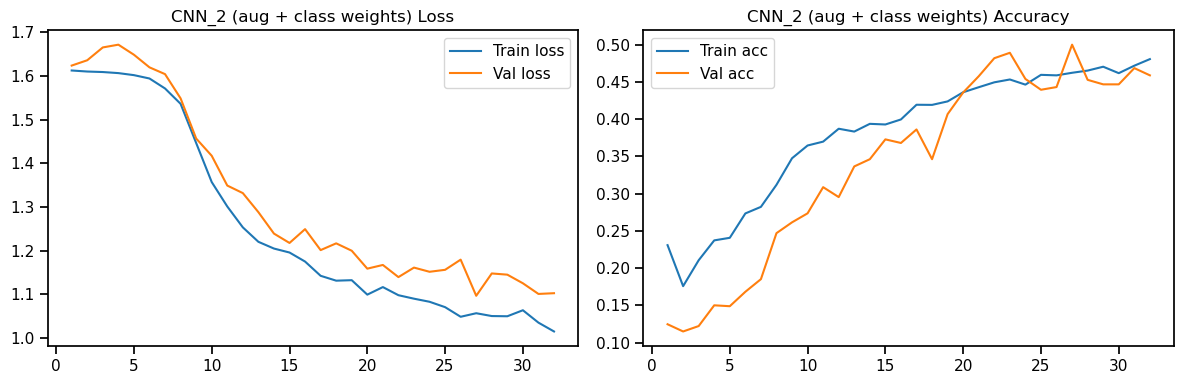

In [26]:
cnn2_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

early_stopping_cnn2 = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history_cnn2 = cnn2_model.fit(
    train_ds_prep,
    validation_data=val_ds_prep,
    epochs=40,
    callbacks=[early_stopping_cnn2],
    class_weight=class_weights,   
)

#visualize training curves
plot_training_history(history_cnn2, title_prefix="CNN_2 (aug + class weights)")

here i will evaluate this new model's performance:

52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 0.4807 - loss: 1.1057
CNN_2 — Test accuracy: 0.481
Classification report (CNN_2):
              precision    recall  f1-score   support

     Grade 0       0.61      0.65      0.63       639
     Grade 1       0.23      0.38      0.29       296
     Grade 2       0.56      0.26      0.35       447
     Grade 3       0.56      0.48      0.52       223
     Grade 4       0.52      0.86      0.65        51

    accuracy                           0.48      1656
   macro avg       0.50      0.53      0.49      1656
weighted avg       0.52      0.48      0.48      1656



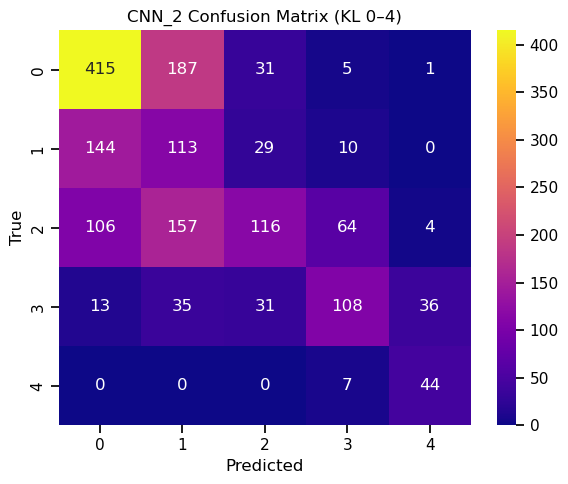

In [27]:
test_loss_cnn2, test_acc_cnn2 = cnn2_model.evaluate(test_ds_prep)
print(f"CNN_2 — Test accuracy: {test_acc_cnn2:.3f}")

from sklearn.metrics import confusion_matrix, classification_report

y_true2, y_pred2 = [], []

for imgs, labels in test_ds_prep:
    preds = cnn2_model.predict(imgs, verbose=0)
    y_true2.extend(labels.numpy())
    y_pred2.extend(np.argmax(preds, axis=1))

y_true2 = np.array(y_true2)
y_pred2 = np.array(y_pred2)

cm2 = confusion_matrix(y_true2, y_pred2)
print("Classification report (CNN_2):")
print(classification_report(y_true2, y_pred2, target_names=[f"Grade {c}" for c in class_names]))

plt.figure(figsize=(6,5))
sns.heatmap(cm2, annot=True, fmt="d", cmap="plasma",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("CNN_2 Confusion Matrix (KL 0–4)")
plt.tight_layout()
plt.show()

This matrix shows that this iteration of CNN model is visibly better than the prior, as shown by the clearer diagonal line. 

Now I will collapse the metrics to binary classification to compare with human metrics. 

=== CNN_2 Diagnostic Metrics (Binary: Healthy vs Arthritic) ===
Sensitivity: 0.741
Specificity: 0.649
PPV:         0.771
NPV:         0.612
Accuracy:    0.706


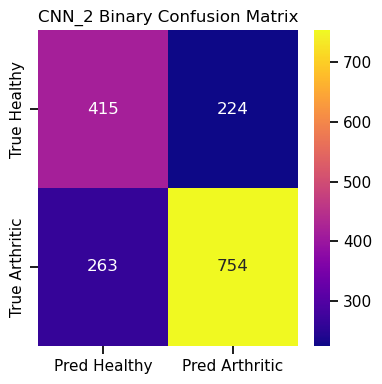

In [28]:
#labels: 0 = healthy, 1 = arthritic (KL 1–4)
y_true2_binary = (y_true2 > 0).astype(int)
y_pred2_binary = (y_pred2 > 0).astype(int)

cm2_bin = confusion_matrix(y_true2_binary, y_pred2_binary)
TN, FP, FN, TP = cm2_bin.ravel()

cnn2_sensitivity = TP / (TP + FN) 
cnn2_specificity = TN / (TN + FP) 
cnn2_ppv         = TP / (TP + FP) 
cnn2_npv         = TN / (TN + FN) 
cnn2_accuracy    = (TP + TN) / cm2_bin.sum()

print("=== CNN_2 Diagnostic Metrics (Binary: Healthy vs Arthritic) ===")
print(f"Sensitivity: {cnn2_sensitivity:.3f}")
print(f"Specificity: {cnn2_specificity:.3f}")
print(f"PPV:         {cnn2_ppv:.3f}")
print(f"NPV:         {cnn2_npv:.3f}")
print(f"Accuracy:    {cnn2_accuracy:.3f}")

plt.figure(figsize=(4,4))
sns.heatmap(cm2_bin, annot=True, fmt="d", cmap="plasma",
            xticklabels=["Pred Healthy","Pred Arthritic"],
            yticklabels=["True Healthy","True Arthritic"])
plt.title("CNN_2 Binary Confusion Matrix")
plt.tight_layout()
plt.show()

Here I will rebuild my comparison table to include this 2nd CNN model's metrics:

In [29]:
#traditional radiology metrics from paper
rad_accuracy    = 0.73
rad_sensitivity = 0.54
rad_specificity = 0.92
rad_ppv         = 0.88
rad_npv         = 0.66

comparison_df = pd.DataFrame({
    "Metric":       ["Accuracy",       "Sensitivity",       "Specificity",       "PPV",       "NPV"],
    "Humans": [rad_accuracy,     rad_sensitivity,     rad_specificity,     rad_ppv,     rad_npv],
    "CNN v1":       [cnn_accuracy,     cnn_sensitivity,     cnn_specificity,     cnn_ppv,     cnn_npv],
    "CNN v2":       [cnn2_accuracy,    cnn2_sensitivity,    cnn2_specificity,    cnn2_ppv,    cnn2_npv],
    "RNN Model":    [rnn_accuracy,     rnn_sensitivity,     rnn_specificity,     rnn_ppv,     rnn_npv],
}).round(3)

comparison_df


,Metric,Humans,CNN v1,CNN v2,RNN Model
0,Accuracy,0.73,0.720,0.706,0.386
1,Sensitivity,0.54,0.678,0.741,0.000
2,Specificity,0.92,0.786,0.649,1.000
3,PPV,0.88,0.834,0.771,NaN
4,NPV,0.66,0.606,0.612,0.386


Here is a grouped bar chart showing the newest results:

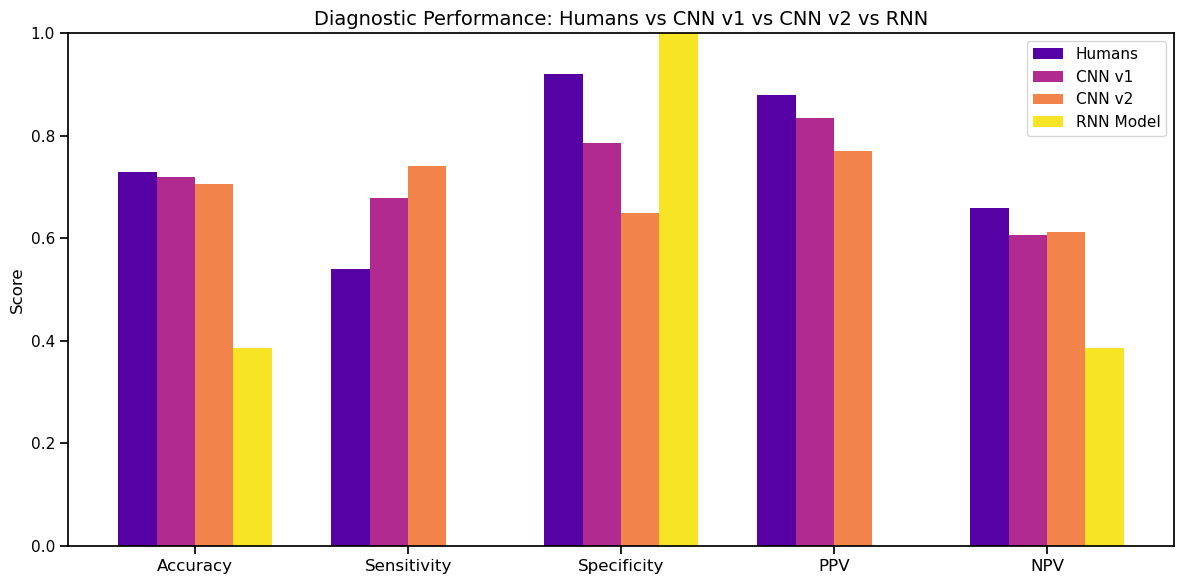

In [30]:
metrics = comparison_df["Metric"].values
radiologists = comparison_df["Humans"].values
cnn_v1_vals  = comparison_df["CNN v1"].values
cnn_v2_vals  = comparison_df["CNN v2"].values
rnn_vals     = comparison_df["RNN Model"].values

x = np.arange(len(metrics))
width = 0.18

plt.figure(figsize=(12,6))

plt.bar(x - 1.5*width, radiologists, width, label="Humans", color=plt.cm.plasma(0.15))
plt.bar(x - 0.5*width, cnn_v1_vals,  width, label="CNN v1",      color=plt.cm.plasma(0.4))
plt.bar(x + 0.5*width, cnn_v2_vals,  width, label="CNN v2",      color=plt.cm.plasma(0.7))
plt.bar(x + 1.5*width, rnn_vals,     width, label="RNN Model",   color=plt.cm.plasma(0.95))

plt.xticks(x, metrics, fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.ylim(0, 1.0)
plt.title("Diagnostic Performance: Humans vs CNN v1 vs CNN v2 vs RNN", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

This was not the result i expected to see, so I will investigate further. Here I will create a confusion breakdown showing true and false negatives and positives of both CNNs. 

In [31]:
def print_confusion_breakdown(cm, name):
    TN, FP, FN, TP = cm.ravel()
    print(f"{name}:")
    print(f"  TN (true healthy)  : {TN}")
    print(f"  FP (false arthritic): {FP}")
    print(f"  FN (missed OA)      : {FN}")
    print(f"  TP (correct OA)     : {TP}")
    print()

print_confusion_breakdown(cm_bin,   "CNN v1 (binary)")
print_confusion_breakdown(cm2_bin,  "CNN v2 (binary)")

CNN v1 (binary):
  TN (true healthy)  : 502
  FP (false arthritic): 137
  FN (missed OA)      : 327
  TP (correct OA)     : 690

CNN v2 (binary):
  TN (true healthy)  : 415
  FP (false arthritic): 224
  FN (missed OA)      : 263
  TP (correct OA)     : 754



Here I can see that my changes created a trade-off situation. The second version missed fewer cases of osteoarthritis (OA), while the first case had fewer false OA diagnoses. 

I'm going to tune the decision threshold for CNN_2 next: 

In [32]:
#i start by getting CNN_2 probabilities on the validation set
val_probs2 = []
val_labels = []

for imgs, labels in val_ds_prep:
    preds = cnn2_model.predict(imgs, verbose=0)
    val_probs2.append(preds)
    val_labels.append(labels.numpy())

val_probs2 = np.concatenate(val_probs2, axis=0)
val_labels = np.concatenate(val_labels, axis=0)

#binary ground truth: 0 = healthy (KL0), 1 = arthritic (KL1-4)
val_true_binary = (val_labels > 0).astype(int)

#probability of "arthritic" = sum of KL1–4 probabilities
val_p_arthritic = val_probs2[:, 1:].sum(axis=1)


In [33]:
#then i will sweep through thresholds and choose the best one
thresholds = np.linspace(0.0, 1.0, 101)

best_t = 0.5
best_bal_acc = -1.0
best_stats = None

for t in thresholds:
    val_pred_bin = (val_p_arthritic >= t).astype(int)
    cm_val = confusion_matrix(val_true_binary, val_pred_bin)
    TN, FP, FN, TP = cm_val.ravel()

    sens = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    spec = TN / (TN + FP) if (TN + FP) > 0 else 0.0
    bal_acc = 0.5 * (sens + spec)

    if bal_acc > best_bal_acc:
        best_bal_acc = bal_acc
        best_t = t
        best_stats = (sens, spec, TN, FP, FN, TP)

print(f"Best threshold (val set): {best_t:.2f}")
print(f"Balanced accuracy: {best_bal_acc:.3f}")
print(f"Sensitivity at best t: {best_stats[0]:.3f}")
print(f"Specificity at best t: {best_stats[1]:.3f}")


Best threshold (val set): 0.71
Balanced accuracy: 0.727
Sensitivity at best t: 0.618
Specificity at best t: 0.835


=== CNN v2 (tuned threshold) Diagnostic Metrics ===
Sensitivity: 0.578
Specificity: 0.862
PPV:         0.870
NPV:         0.562
Accuracy:    0.688


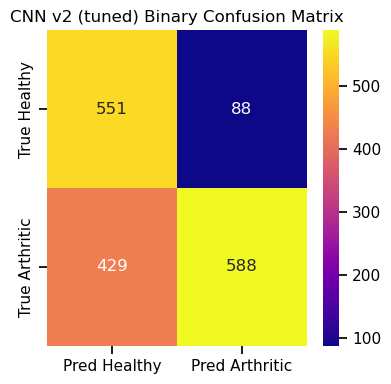

In [34]:
#now i can recompute the CNN_2 test metrics using the above threshold
#get CNN v2 probabilities on the test set
test_probs2 = []
test_labels2 = []

for imgs, labels in test_ds_prep:
    preds = cnn2_model.predict(imgs, verbose=0)
    test_probs2.append(preds)
    test_labels2.append(labels.numpy())

test_probs2 = np.concatenate(test_probs2, axis=0)
test_labels2 = np.concatenate(test_labels2, axis=0)

test_true_binary = (test_labels2 > 0).astype(int)
test_p_arthritic = test_probs2[:, 1:].sum(axis=1)

#use my tuned threshold
test_pred_bin = (test_p_arthritic >= best_t).astype(int)

cm2_bin_tuned = confusion_matrix(test_true_binary, test_pred_bin)
TN, FP, FN, TP = cm2_bin_tuned.ravel()

cnn2_tuned_sensitivity = TP / (TP + FN)
cnn2_tuned_specificity = TN / (TN + FP)
cnn2_tuned_ppv         = TP / (TP + FP)
cnn2_tuned_npv         = TN / (TN + FN)
cnn2_tuned_accuracy    = (TP + TN) / cm2_bin_tuned.sum()

print("=== CNN v2 (tuned threshold) Diagnostic Metrics ===")
print(f"Sensitivity: {cnn2_tuned_sensitivity:.3f}")
print(f"Specificity: {cnn2_tuned_specificity:.3f}")
print(f"PPV:         {cnn2_tuned_ppv:.3f}")
print(f"NPV:         {cnn2_tuned_npv:.3f}")
print(f"Accuracy:    {cnn2_tuned_accuracy:.3f}")

plt.figure(figsize=(4,4))
sns.heatmap(cm2_bin_tuned, annot=True, fmt="d", cmap="plasma",
            xticklabels=["Pred Healthy","Pred Arthritic"],
            yticklabels=["True Healthy","True Arthritic"])
plt.title("CNN v2 (tuned) Binary Confusion Matrix")
plt.tight_layout()
plt.show()

Here is a stacked bar chart, now including the tuned data

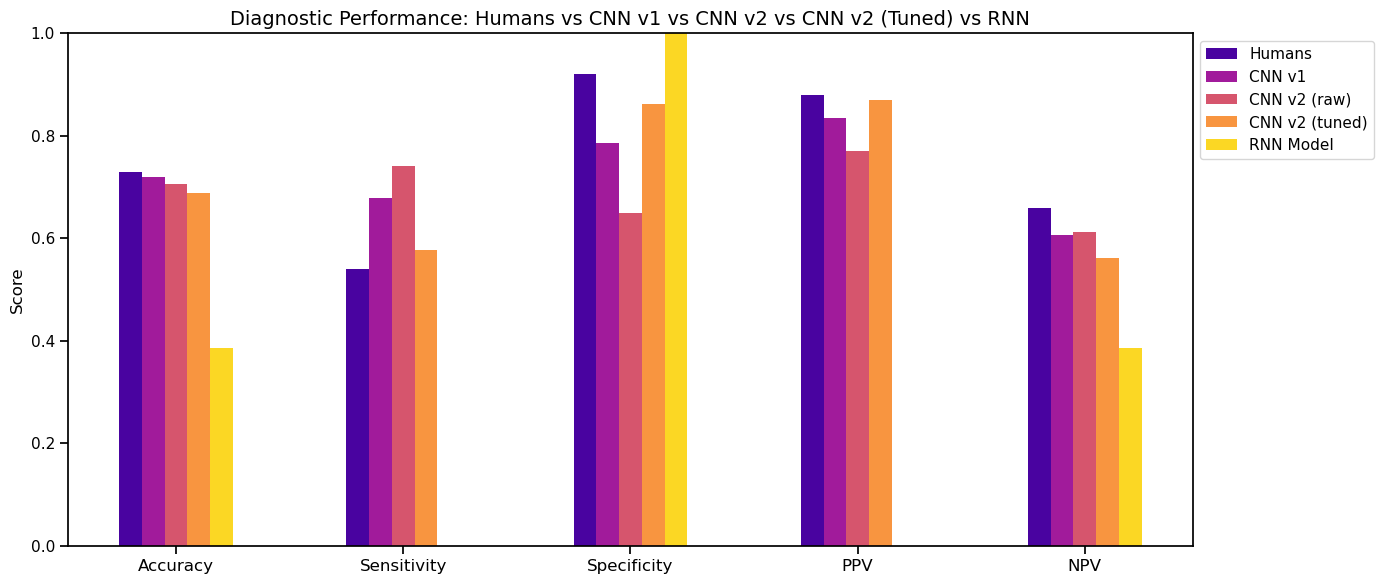

In [36]:
metrics        = comparison_df["Metric"].values
radiologists   = comparison_df["Humans"].values
cnn_v1_vals    = comparison_df["CNN v1"].values
cnn_v2_vals    = comparison_df["CNN v2"].values
cnn_v2_tuned_vals = np.array([
    cnn2_tuned_accuracy,
    cnn2_tuned_sensitivity,
    cnn2_tuned_specificity,
    cnn2_tuned_ppv,
    cnn2_tuned_npv
])
rnn_vals       = comparison_df["RNN Model"].values

#X positions and bar width
x = np.arange(len(metrics))
width = 0.1   #smaller width to fit 5 bars more aesthetically

plt.figure(figsize=(14,6))

plt.bar(x - 2*width, radiologists,        width, label="Humans",        color=plt.cm.plasma(0.12))
plt.bar(x - 1*width, cnn_v1_vals,         width, label="CNN v1",        color=plt.cm.plasma(0.35))
plt.bar(x + 0*width, cnn_v2_vals,         width, label="CNN v2 (raw)",  color=plt.cm.plasma(0.55))
plt.bar(x + 1*width, cnn_v2_tuned_vals,   width, label="CNN v2 (tuned)",color=plt.cm.plasma(0.75))
plt.bar(x + 2*width, rnn_vals,            width, label="RNN Model",     color=plt.cm.plasma(0.92))

plt.xticks(x, metrics, fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.ylim(0, 1.0)
plt.title("Diagnostic Performance: Humans vs CNN v1 vs CNN v2 vs CNN v2 (Tuned) vs RNN", fontsize=14)

plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

This shows that by calibrating the decision threshold using the validation set, I was able to get to a better balance and improved overall performance. 

The first CNN model, as well as the tuned version of the second CNN model are comparable with human doctor/baseline results. The raw CNN version 2 lost some accuracy because it favored sensitivity over specificity. 

Sensitivity: This is the ability to actually detect the arthritis. CNN version 2 (raw) was the best overall at detecting the disease, closely followed by CNN version 1. CNN version 2 still performed higher than the human level. 

Specificity: This is the ability to detect healthy joints. Humans scored the highest here, at 92%. CNN version 2 (tuned) was the best ML performer here, scoring a respectable 86%. Without tuning, the second version scores the lowest in this category, insinuating that it is likely overpredicting instances of OA. 

PPV (Positive Predictive Value): This is the chance that the knee is actually arthritic if the model predicts it to be. Humans score the highest at 88%, while the second version of the CNN model score extremely close behind, at ~87%. 

NPV (Negative Predictive Value): This is measuring how reliable a 'healthy' prediction is. Humans, at 66%, are not very reliable in this instance; however none of the models score any better. All CNN models, however, all score above 55%, giving reasonably close to human performance. 

NOTE: RNN does not appear in the categories of Sensitivity and PPV, above, as it collapsed to a trivial classifier, giving perfect specificity but terrible sensitivity, and no true positives, so the PPV is undefined. It is therefore considered to be an inappropriate method of radiographical OA classification. 

## Results:

Of the models used in this project, I believe the second CNN iteration (tuned) has the most promise. It was able to achieve nearly human-level confidence with positive diagnoses, as shown by its PPV. While it favored sensitivity over specificity, I believe it to be the best baseline for future iterations of the applicaiton of deep learning for OA diagnoses. 

I am an author on a couple JAVMA (veterinary) research papers in the OA space, and in the future hope to adapt this model for use on canine and equine patellar joints (dog and horse analogs to the human knee). 
* DOIs of OA papers in which I have authorship as of the time I originally wrote this code: 10.2460/javma.25.06.0398  and also 10.2460/javma.24.10.0651 if you are interested

For future applications, given the possibility of obtaining more resources and more time, here are some further refinements I would consider looking into:
* investigate different methods for cropping the images, possibly employing a simple bounding-box or even a separate segmentation model
* experiment with higher resolution images to preserve views of smaller osteophytes and more subtlety in general
* research further into noise & artifact handling as there is the possibility of over and under radiographic exposure
* investigate effects of ensembling, different pooling methods, residual/skip connections
* train on a larger and more diverse dataset (including the multi-species goal)
* greater computational power, use a stronger GPU to experiment with higher resolutions, larger batch sizes, deeper models, etc
* it would also be ideal to acquire more data on human accuracy instead of just relying on the one study I was able to find. I would love to instigate my own study into the matter to personally have more confidence in my own baseline data. 


